# COVID19DB PROJECT (www.covid19db.org): covid19 - confirmed cases, administrative division for Poland


This notebook demonstrates how to connect to COVID19db Postgres database and how to generate country level visualisaion.

In [653]:
import psycopg2
import pandas as pd
from pandas.plotting import register_matplotlib_converters 
register_matplotlib_converters()
import matplotlib.pyplot as plt

# Connect to covid19db.org
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19_test',
    user='covid19',
    password='covid19'
)
cur = conn.cursor()

# Retrieving epidemiology data for single source 

In [654]:
# Load all data for region 1
sql_command = """SELECT * FROM epidemiology WHERE source = %(source)s AND adm_area_1 <> '' ORDER by date DESC"""
df = pd.read_sql(sql_command, conn, params={'source': 'POL_WIKI'})
df.head()

,source,date,country,countrycode,adm_area_1,adm_area_2,adm_area_3,tested,confirmed,recovered,dead,hospitalised,hospitalised_icu,quarantined,gid
0,POL_WIKI,2020-05-26,Poland,POL,Pomorskie,None,None,None,541.0,None,32.0,None,None,None,[POL.11_1]
1,POL_WIKI,2020-05-26,Poland,POL,Świętokrzyskie,None,None,None,399.0,None,21.0,None,None,None,[POL.13_1]
2,POL_WIKI,2020-05-26,Poland,POL,Śląskie,None,None,None,7327.0,None,NaN,None,None,None,[POL.12_1]
3,POL_WIKI,2020-05-26,Poland,POL,Warmińsko-Mazurskie,None,None,None,179.0,None,NaN,None,None,None,[POL.14_1]
4,POL_WIKI,2020-05-26,Poland,POL,Wielkopolskie,None,None,None,2054.0,None,NaN,None,None,None,[POL.15_1]


# Extracting only recent data - total per region

In [655]:
df_recent = df.copy()
df_recent['gid'] = [','.join(map(str, l)) for l in df['gid']]
df_recent = df_recent.sort_values('date').groupby('adm_area_1').apply(lambda x: x.max())

df_recent = df_recent.set_index('date')
df_recent[["country", "adm_area_1", "confirmed", "recovered", "dead", "gid"]].head(30)

,country,adm_area_1,confirmed,recovered,dead,gid
date,,,,,,
2020-05-26,Poland,Dolnośląskie,2465.0,None,98.0,POL.1_1
2020-05-25,Poland,Kujawsko-Pomorskie,594.0,None,46.0,POL.2_1
2020-05-26,Poland,Lubelskie,449.0,None,15.0,POL.4_1
2020-05-25,Poland,Lubuskie,108.0,None,NaN,POL.5_1
2020-05-25,Poland,Mazowieckie,3283.0,None,252.0,POL.7_1
2020-05-26,Poland,Małopolskie,1179.0,None,41.0,POL.6_1
2020-05-26,Poland,Opolskie,601.0,None,45.0,POL.8_1
2020-05-24,Poland,Podkarpackie,378.0,None,35.0,POL.9_1
2020-05-26,Poland,Podlaskie,427.0,None,9.0,POL.10_1


### Retrieving administrative division level 1 for single country from covid19db

In [656]:
# Get Covid19db administrative division
import geopandas as gpd
def get_administrative_division(level=0, countrycode=None):
    sql = f"SELECT * FROM administrative_division WHERE adm_level={level} "
    if level>0 and countrycode: 
        sql = sql +  f"AND countrycode='{countrycode}'"

    admin_data = gpd.GeoDataFrame.from_postgis(sql, conn, geom_col='geometry')
    admin_data["area"] = admin_data['geometry'].area
    return admin_data

In [657]:
admin_1_data = get_administrative_division(level=1, countrycode='POL')
admin_1_data.head()

,country,countrycode,countrycode_alpha2,adm_level,adm_area_1,adm_area_1_code,adm_area_2,adm_area_2_code,adm_area_3,adm_area_3_code,gid,latitude,longitude,properties,geometry,area
0,Poland,POL,PL,1,Dolnośląskie,POL.1_1,None,None,None,None,POL.1_1,51.090451,16.411440,"{'CC_1': '02', 'GID_0': 'POL', 'GID_1': 'POL.1...","POLYGON ((15.06966 51.01997, 15.03803 51.01222...",2.554630
1,Poland,POL,PL,1,Kujawsko-Pomorskie,POL.2_1,None,None,None,None,POL.2_1,53.072704,18.488217,"{'CC_1': '04', 'GID_0': 'POL', 'GID_1': 'POL.2...","POLYGON ((18.23998 52.48726, 18.20458 52.48317...",2.411728
2,Poland,POL,PL,1,Łódzkie,POL.3_1,None,None,None,None,POL.3_1,51.604865,19.417596,"{'CC_1': '10', 'GID_0': 'POL', 'GID_1': 'POL.3...","POLYGON ((19.81074 50.90792, 19.72790 50.84328...",2.364374
3,Poland,POL,PL,1,Lubelskie,POL.4_1,None,None,None,None,POL.4_1,51.221061,22.899078,"{'CC_1': '06', 'GID_0': 'POL', 'GID_1': 'POL.4...","POLYGON ((23.40326 50.30130, 23.43580 50.34699...",3.227790
4,Poland,POL,PL,1,Lubuskie,POL.5_1,None,None,None,None,POL.5_1,52.196173,15.342746,"{'CC_1': '08', 'GID_0': 'POL', 'GID_1': 'POL.5...","POLYGON ((15.12407 51.43452, 15.08793 51.42726...",1.838208


# Merge administrative division and epidemiology data


In [640]:
data_pd = df_recent.merge(admin_1_data, how = 'outer', left_on = 'gid', right_on = 'gid', suffixes=('', '_y'))
data_pd = gpd.GeoDataFrame(data_pd, geometry='geometry')
data_pd.head()

,source,country,countrycode,adm_area_1,adm_area_2,adm_area_3,tested,confirmed,recovered,dead,...,adm_area_1_code,adm_area_2_y,adm_area_2_code,adm_area_3_y,adm_area_3_code,latitude,longitude,properties,geometry,area
0,POL_WIKI,Poland,POL,Dolnośląskie,None,None,None,2125.0,None,82.0,...,POL.1_1,None,None,None,None,51.090451,16.411440,"{'CC_1': '02', 'GID_0': 'POL', 'GID_1': 'POL.1...","POLYGON ((15.06966 51.01997, 15.03803 51.01222...",2.554630
1,POL_WIKI,Poland,POL,Kujawsko-Pomorskie,None,None,None,578.0,None,40.0,...,POL.2_1,None,None,None,None,53.072704,18.488217,"{'CC_1': '04', 'GID_0': 'POL', 'GID_1': 'POL.2...","POLYGON ((18.23998 52.48726, 18.20458 52.48317...",2.411728
2,POL_WIKI,Poland,POL,Lubelskie,None,None,None,400.0,None,14.0,...,POL.4_1,None,None,None,None,51.221061,22.899078,"{'CC_1': '06', 'GID_0': 'POL', 'GID_1': 'POL.4...","POLYGON ((23.40326 50.30130, 23.43580 50.34699...",3.227790
3,POL_WIKI,Poland,POL,Lubuskie,None,None,None,92.0,None,NaN,...,POL.5_1,None,None,None,None,52.196173,15.342746,"{'CC_1': '08', 'GID_0': 'POL', 'GID_1': 'POL.5...","POLYGON ((15.12407 51.43452, 15.08793 51.42726...",1.838208
4,POL_WIKI,Poland,POL,Mazowieckie,None,None,None,2902.0,None,229.0,...,POL.7_1,None,None,None,None,52.345758,21.096445,"{'CC_1': '14', 'GID_0': 'POL', 'GID_1': 'POL.7...","POLYGON ((21.06840 51.20693, 21.05656 51.15711...",4.687067


# TEST 1: Checking unmatched regions

### Result should be empty - if not try to correct your fetcher, probably there is a mismatch in adm_areas

In [642]:
# If this is not empty region matching has to be corrected !!!!!
unmatched_regions = data_pd[(data_pd.geometry.isna() | data_pd.countrycode.isna() | data_pd.countrycode_y.isna())]
unmatched_regions

,source,country,countrycode,adm_area_1,adm_area_2,adm_area_3,tested,confirmed,recovered,dead,...,adm_area_1_code,adm_area_2_y,adm_area_2_code,adm_area_3_y,adm_area_3_code,latitude,longitude,properties,geometry,area


# Plotting functions

In [658]:
from termcolor import colored
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import geoplot as gplt

def choropleth_administrative_division(data, hue, label=None, cmap='Reds', k=10, add_text=False):
    schema = mc.Quantiles(data[hue], k=k) 
    gplt.choropleth(
        data,     
        hue=hue,     
        edgecolor='white', 
        linewidth=1,
        cmap=cmap,
        scheme=schema,
        legend=True, 
        legend_kwargs={'bbox_to_anchor': (1, 0.9), 'frameon': False},
    )
    if add_text:
        label = label or hue
        for _, row in data.iterrows():
          plt.text(s=row[label], x = row['longitude'], y = row['latitude'],
                   horizontalalignment='center', 
                   fontdict = {'weight': 'bold', 'size': 10, 'family': 'serif', 'color':  'darkgray',})
        
        
def plot_time_series(data, col):
    for key, grp in df.groupby(['adm_area_1']): 
        grp = grp[grp[col].notna()] # Drop NA
        plt.plot(grp.date, grp[col], '-o', linewidth=4.0, label=key)
        if not grp[col].is_monotonic_decreasing:
            print(colored(f'Series in not monotonic increasing: {key}', 'red'))
            print(grp[['date', col]])

    plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5)) 
    plt.grid()
    plt.title(f'{col} cases per adm_area_1');
    plt.show()

# TEST 2: Regions matching test - check if data is matched correctly with regions

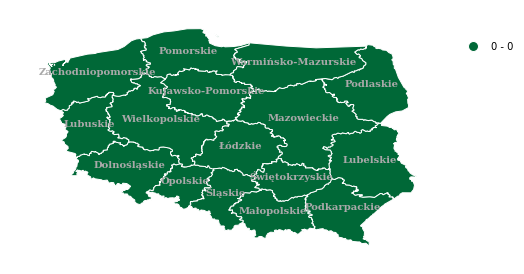

In [646]:
def check(x):
    if pd.isnull(x['countrycode']) or pd.isnull(x['countrycode_y']):
        return 1
    return 0
    
data_pd['errors'] = data_pd.apply(lambda x: check(x), axis=1)
choropleth_administrative_division(data_pd, 'errors', 
                                   label='adm_area_1', 
                                   cmap='RdYlGn_r', 
                                   add_text=True,
                                   k=len(data_pd.errors.unique()))

# Red - problem (incorrect matching, data missing)
# Green - OK

# Plot epidemiology total confirmed


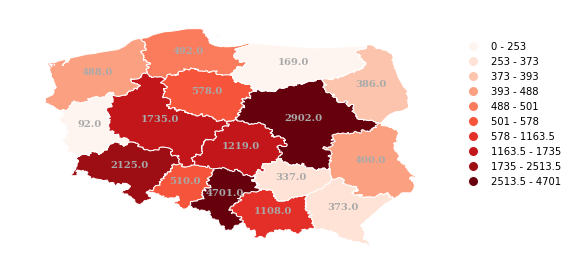

In [647]:
data_pd['confirmed'].fillna(0, inplace = True)
choropleth_administrative_division(data_pd, 'confirmed', add_text=True)

# Plot epidemiology total deaths

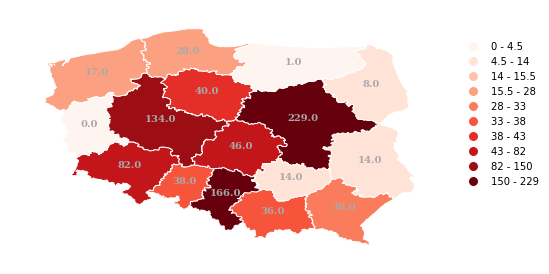

In [648]:
data_pd['dead'].fillna(0, inplace = True)
choropleth_administrative_division(data_pd, 'dead', add_text=True)

# TEST 3: checking the monotonicity of data - confirmed

Series in not monotonic increasing: Podlaskie
           date  confirmed
11   2020-05-14      386.0
28   2020-05-12      385.0
59   2020-05-10      384.0
95   2020-05-08      383.0
100  2020-05-07      381.0
124  2020-05-06      380.0
133  2020-05-05      379.0
160  2020-05-03      378.0
170  2020-05-02      377.0
197  2020-04-30      375.0
230  2020-04-28      367.0
248  2020-04-27      365.0
259  2020-04-26      361.0
266  2020-04-25      358.0
280  2020-04-24      344.0
300  2020-04-23      341.0
319  2020-04-22      335.0
332  2020-04-21      332.0
351  2020-04-20      327.0
365  2020-04-19      321.0
381  2020-04-18      316.0
389  2020-04-17      291.0
407  2020-04-16      278.0
419  2020-04-15      259.0
438  2020-04-14      256.0
450  2020-04-13      238.0
464  2020-04-12      222.0
486  2020-04-11      195.0
492  2020-04-10      189.0
519  2020-04-09      168.0
525  2020-04-08      149.0
544  2020-04-07      127.0
556  2020-04-06      109.0
575  2020-04-05       91.0
585  2020

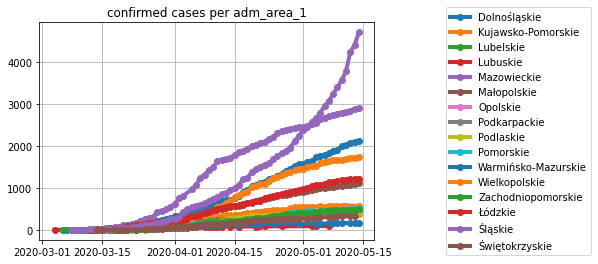

In [649]:
plot_time_series(df, 'confirmed')

# TEST 4: checking the monotonicity of data - dead

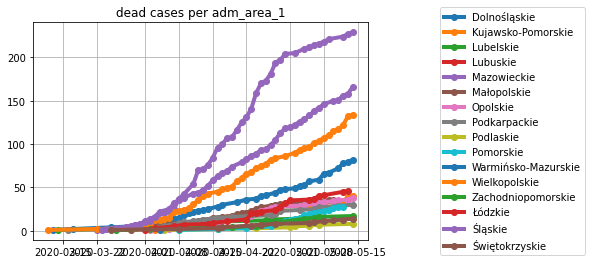

In [650]:
plot_time_series(df, 'dead')